In [4]:
import os
import tensorflow as tf

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("TensorFlow version:", tf.__version__)
print("Available GPU :", tf.config.list_physical_devices('GPU'))
print("Is Built with CUDA:", tf.test.is_built_with_cuda())

TensorFlow version: 2.14.1
Available GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is Built with CUDA: True


In [5]:
img_height, img_width = 56, 56
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/val",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 5367 files belonging to 9 classes.
Found 1007 files belonging to 9 classes.
Found 340 files belonging to 9 classes.


Classes found: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']
Number of classes: 9


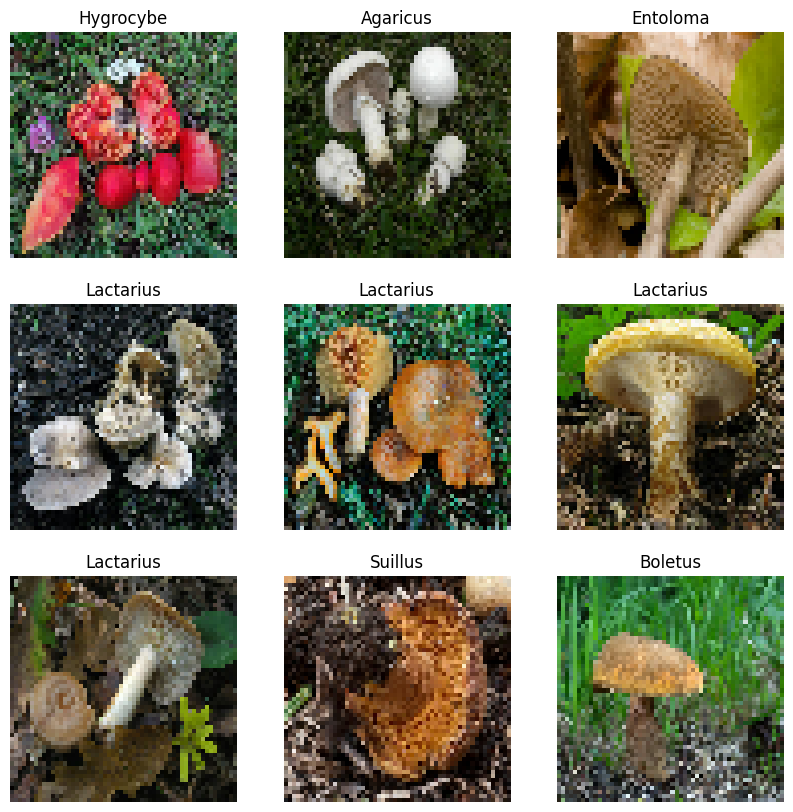

In [6]:
import matplotlib.pyplot as plt

classes = os.listdir('dataset/train')
classes.sort()
num_classes = len(classes)

print("Classes found:", classes)
print("Number of classes:", num_classes)

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

plt.show()

In [7]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
from keras.layers import RandomTranslation, RandomContrast, RandomBrightness, RandomFlip, RandomRotation, RandomZoom
from keras import Sequential

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomFlip("vertical"),
    RandomRotation(0.2),
    RandomZoom(0.1),
    # RandomContrast(0.2),
    # RandomBrightness(0.2),
    # RandomTranslation(height_factor=0.2, width_factor=0.2)
])

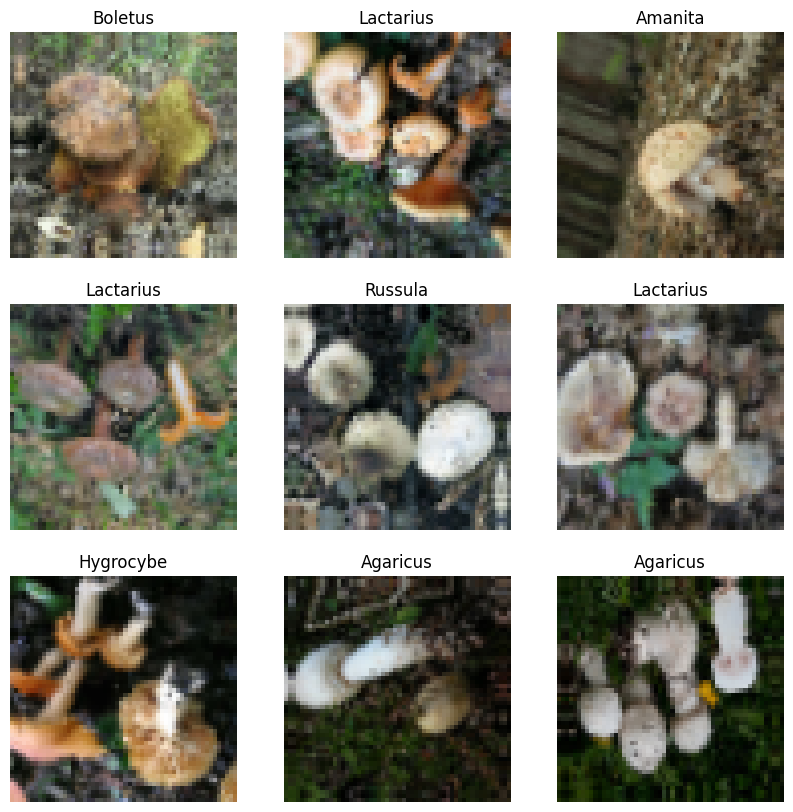

In [9]:
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)  # Positioning in the second row
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

plt.show()

In [10]:
from keras.applications import MobileNetV2

# augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
preprocess_input_mobilenet_v2 = tf.keras.applications.mobilenet_v2.preprocess_input

base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3), 
    include_top=False, 
    weights='imagenet'
    )

base_model.trainable = False

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.001))
prediction_batch = prediction_layer(feature_batch_average)
batch_norm_layer = tf.keras.layers.BatchNormalization()  # Batch Normalization layer

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input_mobilenet_v2(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
# x = batch_norm_layer(x)  # Apply Batch Normalization
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

2023-11-25 02:04:32.315246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-25 02:04:32.405822: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [11]:
from keras.optimizers import Adam

model.compile(
    optimizer=Adam(), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 56, 56, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 56, 56, 3)         0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 56, 56, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 56, 56, 3)         0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                             

In [12]:
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

epoch = 50
weight_name = "weight/mobilenetv2_fungus"+ str(num_classes) +"_epoch" + str(epoch)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

model_checkpoint = ModelCheckpoint(
    filepath=weight_name + '_best',  # Note: no file extension like '.h5'
    monitor='val_loss',
    save_best_only=True,
    save_format='tf'  # This specifies the SavedModel format
)

log_dir = os.path.join(weight_name + "_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

print("TensorBoard log directory:", log_dir)

TensorBoard log directory: weight/mobilenetv2_fungus9_epoch50_logs/20231125-020433


In [13]:
model.fit(
    # augmented_train_ds,
    train_ds,
    validation_data=val_ds,
    epochs=epoch,
    # callbacks=[early_stopping, model_checkpoint, tensorboard_callback]
    callbacks=[model_checkpoint]
)

Epoch 1/50
  5/168 [..............................] - ETA: 2s - loss: 8.3305 - accuracy: 0.1500  

2023-11-25 02:04:37.518165: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3b4c46bb70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-25 02:04:37.518209: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-11-25 02:04:37.521715: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-25 02:04:37.584132: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


146/168 [=========================>....] - ETA: 0s - loss: 4.5453 - accuracy: 0.1738

2023-11-25 02:04:39.742701: E tensorflow/core/lib/jpeg/jpeg_mem.cc:327] Premature end of JPEG data. Stopped at line 494/533


InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) INVALID_ARGUMENT:  jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_11725]

In [ ]:
model.save(weight_name + '_final')
model.evaluate(test_ds)

In [ ]:
import numpy as np

plt.figure(figsize=(10, 20))

for images, labels in test_ds.take(1):
    classifications = model(images)

    for i in range(5):
        ax = plt.subplot(5, 1, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        index = np.argmax(classifications[i])
        probabilities = tf.nn.softmax(classifications[i]).numpy()
        confidence = np.max(probabilities) * 100
        
        plt.title(f"Pred: {classes[index]} ({confidence:.2f}% confidence) | Real: {classes[labels[i]]}")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(weight_name + ".tflite", 'wb') as f:
  f.write(tflite_model)